### Imports

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd 
import os 
import yaml
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [3]:

from qbt.strategies.strategy_registry import create_strategy, available_strategies 


In [4]:
style_path = os.path.join(os.getcwd(), 'styler.mplstyle')
plt.style.use(style_path)

### Main Configs

In [5]:

SELECTION_YEARS=2   # 1, 2, 3 
STATE_VAR = 'RVOL' # RVOL, GARCH, EWMA, 
TRAIN_MEHTOD = 'roll' # roll fixed 
W_OPTIMIZATION = 'MV' 
EXECUTION_TYPE = 'C2C'

## Sample Run

Load Data

In [8]:
def load_data():
    path = os.path.join(os.getcwd(), '..', 'data', 'gold', 'freq=1D', 'tag=model_ready', 'table.parquet')
    df = pd.read_parquet(path)
    df.set_index('session_date', inplace=True)
    return df

In [9]:
df = load_data()

In [10]:
df

,open,high,low,close,volume,rv,rvol,asof_utc,ticker,ret_cc,ret_oo,ret_co,ret_oc
session_date,,,,,,,,,,,,,
2021-01-04 00:00:00+00:00,15.890,16.010,15.55,15.710,1006082,0.000385,0.019632,2021-01-04 21:00:00+00:00,XLE,NaN,NaN,NaN,-0.011393
2021-01-05 00:00:00+00:00,15.890,16.860,15.89,16.440,1671622,0.000501,0.022388,2021-01-05 21:00:00+00:00,XLE,0.045420,0.000000,0.011393,0.034027
2021-01-06 00:00:00+00:00,16.770,17.090,16.55,16.940,1118084,0.000610,0.024700,2021-01-06 21:00:00+00:00,XLE,0.029960,0.053902,0.019874,0.010086
2021-01-07 00:00:00+00:00,17.020,17.350,16.92,17.180,767390,0.000237,0.015391,2021-01-07 21:00:00+00:00,XLE,0.014068,0.014798,0.004711,0.009357
2021-01-08 00:00:00+00:00,17.360,17.390,17.04,17.170,719310,0.000288,0.016963,2021-01-08 21:00:00+00:00,XLE,-0.000582,0.019780,0.010423,-0.011005
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2026-02-11 00:00:00+00:00,54.295,55.100,54.28,54.980,2545121,0.000063,0.007949,2026-02-11 21:00:00+00:00,XLE,0.025794,0.009438,0.013256,0.012537
2026-02-12 00:00:00+00:00,54.910,55.235,53.76,53.960,3383728,0.000182,0.013501,2026-02-12 21:00:00+00:00,XLE,-0.018726,0.011263,-0.001274,-0.017452
2026-02-13 00:00:00+00:00,54.065,54.570,53.82,54.350,2809476,0.000109,0.010454,2026-02-13 21:00:00+00:00,XLE,0.007202,-0.015508,0.001944,0.005258


split data : train is for fixed data set

In [11]:
def split_data(df: pd.DataFrame, years: int):
    """

    - Use last 5 years of data
    - First `years` years -> selection (Train)
    - Last 2 years -> evaluation (Test)

    Parameters
    ----------
    df : pd.DataFrame
        Must have a DatetimeIndex (daily frequency)
    years : int
        Number of years in selection sample (1, 2, or 3)

    Returns
    -------
    Train : pd.DataFrame
        Selection sample (used to estimate τ*)
    Test : pd.DataFrame
        Evaluation sample (used for trading)
    """
    if years not in {1, 2, 3}:
        raise ValueError("years must be one of {1, 2, 3}")

    if not isinstance(df.index, pd.DatetimeIndex):
        raise TypeError("df must have a DatetimeIndex")

    df = df.sort_index()

    # --- restrict to last 5 years ---
    start_date = df.index.min()
    end_5y = start_date + pd.DateOffset(years=5)

    df_5y = df.loc[start_date:end_5y]

    # --- define cutoffs ---
    test_start = end_5y - pd.DateOffset(years=2)
    train_start =   test_start - pd.DateOffset(years=years)

    # --- split ---
    Train = df_5y.loc[train_start:test_start]
    Test  = df_5y.loc[test_start:end_5y]

    return Train, Test

### Predicted State Variables 

ewma

In [12]:
def add_ewma_forecast(
    df: pd.DataFrame,
    *,
    rv_col: str = "rvol",   # realized VOL (not returns)
    lam: float = 0.94,
    burn_in: int = 252,
    use_today: bool = True,  # True: use var[t] (EOD t -> forecast t+1). False: use var[t-1] (info through t-1).
) -> pd.DataFrame:
    df = df.copy().sort_index()

    vol = df[rv_col].astype(float)
    var = vol ** 2

    # f[t] will represent VAR forecast for t+1 stored at time t
    f = pd.Series(np.nan, index=df.index, dtype="float64")

    if len(df) < burn_in:
        df["ewma"] = np.nan
        return df

    # initialize f at burn_in-1 (first time you start producing forecasts)
    f.iloc[burn_in - 1] = var.iloc[:burn_in].mean()

    for t in range(burn_in, len(df)):
        innovation = var.iloc[t] if use_today else var.iloc[t - 1]
        f.iloc[t] = lam * f.iloc[t - 1] + (1 - lam) * innovation

    df["ewma"] = np.sqrt(f)  # VOL forecast for t+1 stored at t
    return df

In [13]:
df

,open,high,low,close,volume,rv,rvol,asof_utc,ticker,ret_cc,ret_oo,ret_co,ret_oc
session_date,,,,,,,,,,,,,
2021-01-04 00:00:00+00:00,15.890,16.010,15.55,15.710,1006082,0.000385,0.019632,2021-01-04 21:00:00+00:00,XLE,NaN,NaN,NaN,-0.011393
2021-01-05 00:00:00+00:00,15.890,16.860,15.89,16.440,1671622,0.000501,0.022388,2021-01-05 21:00:00+00:00,XLE,0.045420,0.000000,0.011393,0.034027
2021-01-06 00:00:00+00:00,16.770,17.090,16.55,16.940,1118084,0.000610,0.024700,2021-01-06 21:00:00+00:00,XLE,0.029960,0.053902,0.019874,0.010086
2021-01-07 00:00:00+00:00,17.020,17.350,16.92,17.180,767390,0.000237,0.015391,2021-01-07 21:00:00+00:00,XLE,0.014068,0.014798,0.004711,0.009357
2021-01-08 00:00:00+00:00,17.360,17.390,17.04,17.170,719310,0.000288,0.016963,2021-01-08 21:00:00+00:00,XLE,-0.000582,0.019780,0.010423,-0.011005
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2026-02-11 00:00:00+00:00,54.295,55.100,54.28,54.980,2545121,0.000063,0.007949,2026-02-11 21:00:00+00:00,XLE,0.025794,0.009438,0.013256,0.012537
2026-02-12 00:00:00+00:00,54.910,55.235,53.76,53.960,3383728,0.000182,0.013501,2026-02-12 21:00:00+00:00,XLE,-0.018726,0.011263,-0.001274,-0.017452
2026-02-13 00:00:00+00:00,54.065,54.570,53.82,54.350,2809476,0.000109,0.010454,2026-02-13 21:00:00+00:00,XLE,0.007202,-0.015508,0.001944,0.005258


In [108]:
df = add_ewma_forecast(df)
df["ewma_ann"] = df["ewma"] * np.sqrt(252)

garch

In [109]:
from arch import arch_model

In [110]:
def add_garch11_mle(df, ret_col="ret_cc", burn_in=252, scale=100):
    df = df.copy().sort_index()

    r = df[ret_col].astype(float)
    r_scaled = r * scale

    garch_vol = pd.Series(index=df.index, dtype="float64")

    for t in range(burn_in, len(df)):
        train = r_scaled.iloc[:t+1].dropna()

        if len(train) < burn_in:
            continue

        am = arch_model(train, vol="GARCH", p=1, q=1, mean="Zero")
        res = am.fit(disp="off")

        # one-step ahead forecast for time t
        fcast = res.forecast(horizon=1, reindex=False)
        var_forecast = fcast.variance.values[-1, 0]

        # undo scaling properly
        garch_vol.iloc[t] = np.sqrt(var_forecast) / scale

    df["garch11"] = garch_vol
    df.loc[:df.index[burn_in-1], "garch11"] = np.nan


    return df

In [111]:
df = add_garch11_mle(df)
df["garch_ann"] = df["garch11"] * np.sqrt(252)

In [112]:
df

,open,high,low,close,volume,rv,rvol,ticker,ret_cc,ret_oo,ret_co,ret_oc,ewma,ewma_ann,garch11,garch_ann
timestamp,,,,,,,,,,,,,,,,
2021-01-04 05:00:00+00:00,15.890,16.010,15.550,15.710,1006082,0.000385,0.019632,XLE,NaN,NaN,NaN,-0.011393,NaN,NaN,NaN,NaN
2021-01-05 05:00:00+00:00,15.890,16.860,15.890,16.440,1671622,0.000501,0.022388,XLE,0.045420,0.000000,0.011393,0.034027,NaN,NaN,NaN,NaN
2021-01-06 05:00:00+00:00,16.770,17.090,16.550,16.940,1118084,0.000610,0.024700,XLE,0.029960,0.053902,0.019874,0.010086,NaN,NaN,NaN,NaN
2021-01-07 05:00:00+00:00,17.020,17.350,16.920,17.180,767390,0.000237,0.015391,XLE,0.014068,0.014798,0.004711,0.009357,NaN,NaN,NaN,NaN
2021-01-08 05:00:00+00:00,17.360,17.390,17.040,17.170,719310,0.000288,0.016963,XLE,-0.000582,0.019780,0.010423,-0.011005,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2026-02-06 05:00:00+00:00,52.455,53.415,52.400,53.235,2762693,0.000114,0.010697,XLE,0.019059,0.001717,0.004299,0.014760,0.011295,0.179300,0.015777,0.250457
2026-02-09 05:00:00+00:00,53.205,53.715,52.985,53.630,2140349,0.000072,0.008482,XLE,0.007393,0.014197,-0.000564,0.007956,0.011146,0.176939,0.015481,0.245746
2026-02-10 05:00:00+00:00,53.785,53.785,53.240,53.580,1815183,0.000043,0.006553,XLE,-0.000933,0.010842,0.002886,-0.003819,0.010925,0.173431,0.015113,0.239915


In [113]:
import statsmodels.api as sm

def add_har_rv_forecast(
    df: pd.DataFrame,
    *,
    rv_col: str = "rvol",
    burn_in: int = 252,
) -> pd.DataFrame:

    df = df.copy().sort_index()
    rv = df[rv_col].astype(float)

    # lag features
    df["rv_d"] = rv.shift(1)
    df["rv_w"] = rv.shift(1).rolling(5).mean()
    df["rv_m"] = rv.shift(1).rolling(22).mean()

    df["har_rv"] = np.nan

    for t in range(burn_in, len(df)):
        train = df.iloc[:t+1].dropna(subset=["rv_d", "rv_w", "rv_m"])

        if len(train) < burn_in:
            continue

        X = train[["rv_d", "rv_w", "rv_m"]]
        X = sm.add_constant(X)
        y = train[rv_col]

        model = sm.OLS(y, X).fit()


        # ---- build 1-row exog with the SAME columns/order as X/model ----
        x_row = df.loc[df.index[t], ["rv_d", "rv_w", "rv_m"]]
        if x_row.isna().any():
            continue

        x_fore = pd.DataFrame([x_row.values], columns=["rv_d", "rv_w", "rv_m"])
        x_fore = sm.add_constant(x_fore, has_constant="add")

        # align columns exactly to model params (robust against const issues)
        x_fore = x_fore.reindex(columns=model.params.index, fill_value=0.0)

        df.iat[t, df.columns.get_loc("har_rv")] = float(model.predict(x_fore).iloc[0])


    return df


In [114]:
df = add_har_rv_forecast(df)
df["har_rv_ann"] = df["har_rv"] * np.sqrt(252)

In [115]:
df

,open,high,low,close,volume,rv,rvol,ticker,ret_cc,ret_oo,...,ret_oc,ewma,ewma_ann,garch11,garch_ann,rv_d,rv_w,rv_m,har_rv,har_rv_ann
timestamp,,,,,,,,,,,,,,,,,,,,,
2021-01-04 05:00:00+00:00,15.890,16.010,15.550,15.710,1006082,0.000385,0.019632,XLE,NaN,NaN,...,-0.011393,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-01-05 05:00:00+00:00,15.890,16.860,15.890,16.440,1671622,0.000501,0.022388,XLE,0.045420,0.000000,...,0.034027,NaN,NaN,NaN,NaN,0.019632,NaN,NaN,NaN,NaN
2021-01-06 05:00:00+00:00,16.770,17.090,16.550,16.940,1118084,0.000610,0.024700,XLE,0.029960,0.053902,...,0.010086,NaN,NaN,NaN,NaN,0.022388,NaN,NaN,NaN,NaN
2021-01-07 05:00:00+00:00,17.020,17.350,16.920,17.180,767390,0.000237,0.015391,XLE,0.014068,0.014798,...,0.009357,NaN,NaN,NaN,NaN,0.024700,NaN,NaN,NaN,NaN
2021-01-08 05:00:00+00:00,17.360,17.390,17.040,17.170,719310,0.000288,0.016963,XLE,-0.000582,0.019780,...,-0.011005,NaN,NaN,NaN,NaN,0.015391,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2026-02-06 05:00:00+00:00,52.455,53.415,52.400,53.235,2762693,0.000114,0.010697,XLE,0.019059,0.001717,...,0.014760,0.011295,0.179300,0.015777,0.250457,0.013037,0.014301,0.011102,0.012844,0.203894
2026-02-09 05:00:00+00:00,53.205,53.715,52.985,53.630,2140349,0.000072,0.008482,XLE,0.007393,0.014197,...,0.007956,0.011146,0.176939,0.015481,0.245746,0.010697,0.013084,0.011038,0.011391,0.180825
2026-02-10 05:00:00+00:00,53.785,53.785,53.240,53.580,1815183,0.000043,0.006553,XLE,-0.000933,0.010842,...,-0.003819,0.010925,0.173431,0.015113,0.239915,0.008482,0.011954,0.010971,0.010017,0.159013


### Model

In [116]:

def candidate_thresholds(state_var, n_grid, min_quintile=0):
    s = np.asarray(state_var)
    s = s[~np.isnan(s)]  # defensive: drop NaNs

    if s.size == 0:
        raise ValueError("state_var contains no valid observations")

    if min_quintile > 0:
        qs = np.linspace(min_quintile/2, 1.0 - min_quintile/2, n_grid, endpoint=True)
    else:
        qs = np.linspace(0.0, 1.0, n_grid, endpoint=True)

    candidates = np.unique(np.quantile(s, qs))

    return candidates


def regime_classification(state_var, tau, df):
    mask = state_var <= tau
    low = df[mask]
    high = df[~mask]             
    
    return low, high


def _sharpe(
    ret: pd.Series,
    *,
    rf: pd.Series | None = None,
    ann_factor: int = 252,
) -> float:
    r = ret.dropna()

    if r.empty:
        return np.nan

    if rf is None:
        excess = r
    else:
     
        rf = rf.reindex(r.index)
        rf = rf.ffill()
        excess = r - rf

   

    sd = excess.std(ddof=0)
    if sd <= 0 or np.isnan(sd):
        return np.nan

    return float(excess.mean() / sd * np.sqrt(ann_factor))


def sharpe_ratio_by_regime(
    low: pd.DataFrame,
    high: pd.DataFrame,
    *,
    ret_col: str = "ret_cc",
    risk_free_rate: str = "0%",   # "0%", "TBILL-1M", "TBILL-3M"
    ann_factor: int = 252,
):
    """
    Computes Sharpe ratios for low- and high-regime subsets using the same Sharpe logic.
    """

    # --- extract returns ---
    r_low = low[ret_col].dropna()
    r_high = high[ret_col].dropna()

    # --- build rf series (aligned later inside _sharpe) ---
    if risk_free_rate == "0%" or risk_free_rate is None:
        rf_series_low = None
        rf_series_high = None

    elif risk_free_rate in ("TBILL-1M", "1m", "1M"):
        rf_series_low = (low["TBILL-1M"] ) / ann_factor
        rf_series_high = (high["TBILL-1M"] ) / ann_factor

    elif risk_free_rate in ("TBILL-3M", "3m", "3M"):
        rf_series_low = (low["TBILL-3M"] ) / ann_factor
        rf_series_high = (high["TBILL-3M"] ) / ann_factor

    else:
        raise ValueError(f"Unknown risk_free_rate: {risk_free_rate}")

    # --- Sharpe ratios using the SAME function ---
    sr_low = _sharpe(r_low, rf=rf_series_low, ann_factor=ann_factor)
    sr_high = _sharpe(r_high, rf=rf_series_high, ann_factor=ann_factor)

    return sr_low, sr_high

In [117]:
def choose_threshold(df,state_var, n_grid=100, min_quintile=.10, risk_free_rate='0%'):
    results = []

    tau_star = None
    best_obj = -np.inf
    state_var_arr = df[state_var]

    candidates = candidate_thresholds(state_var_arr, n_grid, min_quintile)
    for tau in candidates:
        low, high = regime_classification(state_var_arr, tau, df)

        n_low = len(low)
        n_high = len(high)
        # if n_low < 5 or n_high < 5:
        #     continue
        
        sr_low, sr_high = sharpe_ratio_by_regime(low, high, risk_free_rate=risk_free_rate)


        if np.isnan(sr_low) or np.isnan(sr_high):
            continue

        obj = sr_low - sr_high


        results.append({'tau': tau, 'sharpe_diff': obj, 'sharpe_low_state': sr_low, 'sharpe_high_state': sr_high, 'n_low': n_low, 'n_high': n_high})


        if obj > best_obj:
            best_obj = obj
            tau_star = float(tau)


    return tau_star, pd.DataFrame(results)





### Back Tesing

In [118]:
def compute_mv_weight(
    df: pd.DataFrame,
    *,
    ret_col: str,
    rf: float = 0.0,
    max_leverage: float = 1.0,
    min_obs: int = 30,
) -> float:
    r = df[ret_col].dropna().astype(float)
    if len(r) < min_obs:
        return 0.0

    mu = float(r.mean() - rf)
    var = float(r.var(ddof=1))
    if var <= 0 or not np.isfinite(var):
        return 0.0

    w = mu / var
    return float(np.clip(w, 0, max_leverage))


In [119]:
def build_signal_and_weights_fixed(
    Train: pd.DataFrame,
    Test: pd.DataFrame,
    *,
    state_var: str,
    ret_col: str,
    weight_method: str = "binary",   # "binary" | "fixed" | "mean_var"
    w_low: float = 0.0,
    w_high: float = 1.0,
    rf_daily: float = 0.0,
    max_leverage: float = 1.0,
) -> pd.DataFrame:
    tau_star, _ = choose_threshold(Train, state_var=state_var)
    tau_star = float(tau_star)

    out = pd.DataFrame(index=Test.index)
    out["state_var"] = Test[state_var].astype(float)

    out["tau_star"] = tau_star
    out["signal"] = (out["state_var"] < tau_star).astype("Int64")  # 1 = LOW regime
    out["w_high_star"] = 1.0
    out["w_low_star"] = 0.0

    base_signal = out["signal"].fillna(0).astype(int)

    if weight_method == "binary":
        out["target_weight"] = base_signal.astype(float) * float(w_high)

    elif weight_method == "fixed":
        out["target_weight"] = np.where(base_signal.values == 1, float(w_high), float(w_low))

    elif weight_method == "mean_var":
        train_sig = (Train[state_var].astype(float) < tau_star).astype("Int64").fillna(0).astype(int)
        tr = Train[[ret_col]].copy()
        tr["signal"] = train_sig

        # signal==1 is LOW regime (by definition)
        w_low_star = compute_mv_weight(
            tr.loc[tr["signal"] == 1],
            ret_col=ret_col,
            rf=rf_daily,
            max_leverage=max_leverage,
        )
        w_high_star = compute_mv_weight(
            tr.loc[tr["signal"] == 0],
            ret_col=ret_col,
            rf=rf_daily,
            max_leverage=max_leverage,
        )

        out["w_high_star"] = float(w_high_star)  # high regime
        out["w_low_star"] = float(w_low_star)    # low regime
        out["target_weight"] = np.where(base_signal.values == 1, float(w_low_star), float(w_high_star))

    else:
        raise ValueError("weight_method must be one of: 'binary', 'fixed', 'mean_var'")

    out["target_weight"] = out["target_weight"].astype("float64")
    return out

def build_signal_and_weights_rolling(
    Train: pd.DataFrame,
    Test: pd.DataFrame,
    *,
    state_var: str,
    ret_col: str,
    lookback: int,
    weight_method: str = "binary",   # "binary" | "fixed" | "mean_var"
    w_low: float = 0.0,
    w_high: float = 1.0,
    rf_daily: float = 0.0,
    max_leverage: float = 1.0,
) -> pd.DataFrame:
    # Build the full time series explicitly (no outer-scope df)
    x = pd.concat([Train, Test], axis=0).sort_index()
    x = x[~x.index.duplicated(keep="last")]

    test_idx = Test.index

    out = pd.DataFrame(index=test_idx)
    out["state_var"] = x.loc[test_idx, state_var].astype(float)
    out["tau_star"] = np.nan
    out["signal"] = pd.NA
    out["target_weight"] = np.nan

    if weight_method == "mean_var":
        out["w_high_star"] = np.nan
        out["w_low_star"] = np.nan

    for t in test_idx:
        sv_t = out.at[t, "state_var"]
        if pd.isna(sv_t):
            continue

        # locate position in x (t should exist, but pad makes this robust)
        end_pos = x.index.get_indexer([t], method="pad")[0]
        if end_pos <= 0:
            continue

        train_end = end_pos - 1
        train_start = max(0, train_end - lookback + 1)
        Train_roll = x.iloc[train_start : train_end + 1]

        if len(Train_roll) < lookback:
            continue

        tau_star, _ = choose_threshold(Train_roll, state_var=state_var)
        tau_star = float(tau_star)

        sig_t = int(float(sv_t) < tau_star)  # 1 = LOW regime

        out.at[t, "tau_star"] = tau_star
        out.at[t, "signal"] = sig_t

        if weight_method == "binary":
            out.at[t, "target_weight"] = float(w_high) if sig_t == 1 else 0.0

        elif weight_method == "fixed":
            out.at[t, "target_weight"] = float(w_high) if sig_t == 1 else float(w_low)

        elif weight_method == "mean_var":
            train_sig = (Train_roll[state_var].astype(float) < tau_star).astype("Int64").fillna(0).astype(int)
            tr = Train_roll[[ret_col]].copy()
            tr["signal"] = train_sig

        

            # signal==1 is LOW regime
            w_low_star = compute_mv_weight(
                tr.loc[tr["signal"] == 1],
                ret_col=ret_col,
                rf=rf_daily,
                max_leverage=max_leverage,
            )
            w_high_star = compute_mv_weight(
                tr.loc[tr["signal"] == 0],
                ret_col=ret_col,
                rf=rf_daily,
                max_leverage=max_leverage,
            )

            out.at[t, "w_high_star"] = float(w_high_star)
            out.at[t, "w_low_star"] = float(w_low_star)
            out.at[t, "target_weight"] = float(w_low_star) if sig_t == 1 else float(w_high_star)

        else:
            raise ValueError("weight_method must be one of: 'binary', 'fixed', 'mean_var'")

    out["signal"] = out["signal"].astype("Int64")
    out["tau_star"] = out["tau_star"].astype("float64")
    out["target_weight"] = out["target_weight"].astype("float64")
    return out


In [120]:
def simulate_trading(
    weights: pd.Series,
    signal: pd.Series,
    rets: pd.Series,
    *,
    tcost_bps: float = 0.0,        # 5 = 5 bps per trade
    apply_on: str = "entry",       # "both" | "entry" | "exit"
    lag: int = 1,                  # use weights_{t-lag} to earn return_t
    add_equity: bool = True,
    returns_are_log: bool = True,  # if False, assumes simple returns
    add_buy_hold: bool = True,     # include buy&hold columns
) -> pd.DataFrame:
    """
    Simple backtest with transaction costs.

    Returns columns:
      weights, position, ret, strat_gross, turnover, trade, tcost, strat_net
      + (optional) equity_gross, equity_net
      + (optional) bh_ret, bh_equity
    """
    w = weights.copy().sort_index().astype("float64")
    r = rets.copy().sort_index().astype("float64")

    # align indexes (keep all ret rows; weights may be missing -> 0)
    x = pd.DataFrame({"weights": w, "ret": r})
    x["weights"] = x["weights"].fillna(0.0)
    x = x.dropna(subset=["ret"])

    x['signal'] = signal
    # position used to earn ret_t
    x["weights"] = x["weights"].shift(lag).fillna(0.0)  # keep float

    # turnover / trades (compare current vs prev position)
    prev = x["weights"].shift(1).fillna(0.0)
    curr = x["weights"]
    x["turnover"] = (curr - prev).abs()

    if apply_on == "entry":
        x["trade"] = ((prev == 0) & (curr != 0)).astype(int)
    elif apply_on == "exit":
        x["trade"] = ((prev != 0) & (curr == 0)).astype(int)
    elif apply_on == "both":
        x["trade"] = (prev != curr).astype(int)
    else:
        raise ValueError("apply_on must be one of: 'both', 'entry', 'exit'")

    # strategy gross + costs (cost charged per trade event; independent of size)
    x["strat_gross"] = x["weights"] * x["ret"]
    x["tcost"] = (tcost_bps / 10_000.0) * x["trade"]
    x["strat_net"] = x["strat_gross"] - x["tcost"]

    if add_buy_hold:
        x["bh_ret"] = x["ret"]  # buy&hold earns raw returns, no costs

    if add_equity:
        if returns_are_log:
            x["equity_gross"] = np.exp(x["strat_gross"].fillna(0.0).cumsum())
            x["equity_net"]   = np.exp(x["strat_net"].fillna(0.0).cumsum())
            if add_buy_hold:
                x["bh_equity"] = np.exp(x["bh_ret"].fillna(0.0).cumsum())
        else:
            x["equity_gross"] = (1.0 + x["strat_gross"].fillna(0.0)).cumprod()
            x["equity_net"]   = (1.0 + x["strat_net"].fillna(0.0)).cumprod()
            if add_buy_hold:
                x["bh_equity"] = (1.0 + x["bh_ret"].fillna(0.0)).cumprod()

    cols = ["weights", "signal", "ret", "strat_gross", "turnover", "trade", "tcost", "strat_net"]
    if add_buy_hold:
        cols += ["bh_ret"]
    if add_equity:
        cols += ["equity_gross", "equity_net"]
        if add_buy_hold:
            cols += ["bh_equity"]

    return x[cols]


execution

In [121]:
def evaluate_strategy(
    df: pd.DataFrame,
    *,
    strat_ret_col: str = "strat_net",   # strategy log returns
    asset_ret_col: str = "ret",      # underlying asset log returns (what you condition Sharpe on)
    signal_col: str = "signal",         # 0/1 or weights
    ann_factor: int = 252,
    rf: str = "0%",                     # "0%", "TBILL-1M"/"1m", "TBILL-3M"/"3m"
) -> dict:

    x = df.copy().sort_index()

    # --- strategy returns for equity + overall sharpe ---
    if strat_ret_col not in x.columns:
        raise ValueError(f"Missing strat_ret_col='{strat_ret_col}'")
    r_strat = x[strat_ret_col].astype(float).dropna()
    if r_strat.empty:
        return {
            "cumulative_return": np.nan,
            "sharpe": np.nan,
            "sharpe_buy_regime": np.nan,
            "sharpe_no_buy_regime": np.nan,
            "num_buy_days": 0,
            "num_no_buy_days": 0,
            "turnover": np.nan,
            "max_drawdown": np.nan,
        }

    # --- signal aligned to strategy dates ---
    if signal_col not in x.columns:
        raise ValueError(f"Missing signal_col='{signal_col}'")
    sig = x[signal_col].reindex(r_strat.index)

    # if signal_col is weights, treat >0 as "buy"
    regime = (sig.astype(float) > 0).astype(int)  # 1=buy, 0=no-buy

    # --- rf series ---
    rf_key = (rf or "0%")
    rf_key_l = rf_key.lower()

    if rf_key == "0%" or rf_key_l in ("0", "none", "null"):
        rf_series = None
    elif rf_key in ("TBILL-1M",) or rf_key_l in ("1m", "tbill-1m", "tbill_1m"):
        if "TBILL-1M" not in x.columns:
            raise ValueError("Missing 'TBILL-1M' for rf='TBILL-1M'")
        rf_series = x["TBILL-1M"].astype(float) / ann_factor
    elif rf_key in ("TBILL-3M",) or rf_key_l in ("3m", "tbill-3m", "tbill_3m"):
        if "TBILL-3M" not in x.columns:
            raise ValueError("Missing 'TBILL-3M' for rf='TBILL-3M'")
        rf_series = x["TBILL-3M"].astype(float) / ann_factor
    else:
        raise ValueError(f"Unknown rf: {rf}")

    def rf_for(ret: pd.Series):
        return None if rf_series is None else rf_series.reindex(ret.index)

    # --- equity + cumulative return (strategy) ---
    equity = np.exp(r_strat.fillna(0).cumsum())
    cumulative_return = float(equity.iloc[-1] - 1.0)

    # --- overall strategy Sharpe ---
    sharpe = _sharpe(r_strat, rf=rf_for(r_strat), ann_factor=ann_factor)

    # --- conditional regime Sharpe on ASSET returns ---
    if asset_ret_col not in x.columns:
        raise ValueError(f"Missing asset_ret_col='{asset_ret_col}'")

    r_asset = x[asset_ret_col].astype(float).reindex(r_strat.index)  # same calendar
    r_buy = r_asset[regime == 1].dropna()
    r_no_buy = r_asset[regime == 0].dropna()
  

    # Buy & hold Sharpe (asset, all days)
    sharpe_bh = _sharpe(r_asset, rf=rf_for(r_asset), ann_factor=ann_factor)
    # sharpe of days where we buy
    sharpe_buy = _sharpe(r_buy, rf=rf_for(r_buy), ann_factor=ann_factor)
    # sharpe of days when we dont buy
    sharpe_no_buy = _sharpe(r_no_buy, rf=rf_for(r_no_buy), ann_factor=ann_factor)

    # --- counts ---
    num_buy_days = int((regime == 1).sum())
    num_no_buy_days = int((regime == 0).sum())

    # --- turnover (on weights/signal series) ---
    turnover = float(sig.astype(float).fillna(0.0).diff().abs().sum())

    # --- max drawdown (strategy equity) ---
    running_max = equity.cummax()
    drawdown = equity / running_max - 1.0
    max_drawdown = float(drawdown.min())

    return {
        "cumulative_return": cumulative_return,
        "sharpe": float(sharpe),
        "sharpe_bh": float(sharpe_bh),
        "sharpe_buy_regime": float(sharpe_buy),
        "sharpe_no_buy_regime": float(sharpe_no_buy),
        "num_buy_days": num_buy_days,
        "num_no_buy_days": num_no_buy_days,
        "turnover": turnover,
        "max_drawdown": max_drawdown,
    }


In [122]:
Train, Test = split_data(df, years=2)

sig = build_signal_and_weights_fixed(Train, Test, state_var="rvol", ret_col='ret_oc', weight_method="mean_var", max_leverage=1)
bt = simulate_trading(sig["target_weight"], sig['signal'], Test["ret_cc"], tcost_bps=5, apply_on="entry", lag=1)

# sig_roll   = build_signal_and_weights_rolling(df, Test, state_var="rvol",ret_col='ret_cc',  lookback=252, weight_method="mean_var")
# bt = simulate_trading(sig_roll["target_weight"], sig_roll['signal'] ,Test["ret_cc"], tcost_bps=5, apply_on="entry", lag=1)

In [123]:
Train.index.min()

Timestamp('2022-01-04 05:00:00+0000', tz='UTC')

In [124]:
Train.index.max()

Timestamp('2024-01-04 05:00:00+0000', tz='UTC')

In [125]:
Test.index.min()

Timestamp('2024-01-04 05:00:00+0000', tz='UTC')

In [126]:
Test.index.max()

Timestamp('2026-01-02 05:00:00+0000', tz='UTC')

In [127]:
sig

,state_var,tau_star,signal,w_high_star,w_low_star,target_weight
timestamp,,,,,,
2024-01-04 05:00:00+00:00,0.009377,0.024249,1,0.0,1.0,1.0
2024-01-05 05:00:00+00:00,0.008761,0.024249,1,0.0,1.0,1.0
2024-01-08 05:00:00+00:00,0.008435,0.024249,1,0.0,1.0,1.0
2024-01-09 05:00:00+00:00,0.007199,0.024249,1,0.0,1.0,1.0
2024-01-10 05:00:00+00:00,0.007370,0.024249,1,0.0,1.0,1.0
...,...,...,...,...,...,...
2025-12-26 05:00:00+00:00,0.004858,0.024249,1,0.0,1.0,1.0
2025-12-29 05:00:00+00:00,0.006788,0.024249,1,0.0,1.0,1.0
2025-12-30 05:00:00+00:00,0.003826,0.024249,1,0.0,1.0,1.0


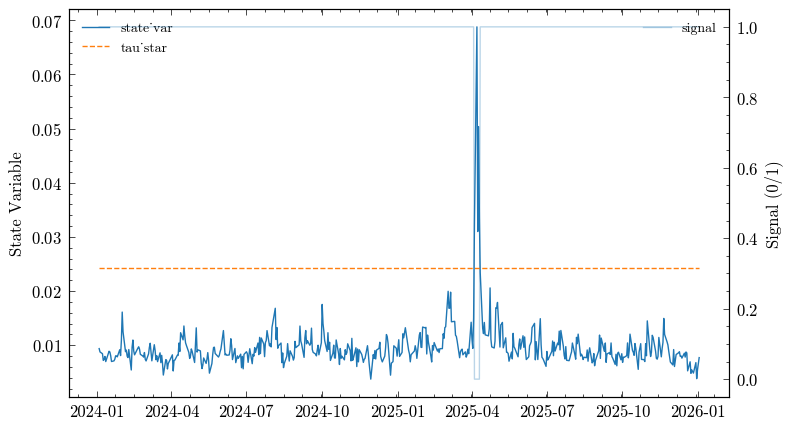

In [128]:
fig, ax1 = plt.subplots(figsize=(8,5))

# left axis → state variable + threshold
ax1.plot(sig.index, sig["state_var"], label="state_var")
ax1.plot(sig.index, sig["tau_star"], label="tau_star", linestyle="--")
ax1.set_ylabel("State Variable")

# right axis → signal
ax2 = ax1.twinx()
ax2.plot(sig.index, sig["signal"], label="signal", alpha=0.3)
ax2.set_ylabel("Signal (0/1)")

ax1.legend(loc="upper left")
ax2.legend(loc="upper right")

plt.show()

In [129]:
bt

,weights,signal,ret,strat_gross,turnover,trade,tcost,strat_net,bh_ret,equity_gross,equity_net,bh_equity
timestamp,,,,,,,,,,,,
2024-01-04 05:00:00+00:00,0.0,1,-0.016752,-0.000000,0.0,0,0.0000,-0.000000,-0.016752,1.000000,1.000000,0.983387
2024-01-05 05:00:00+00:00,1.0,1,0.000504,0.000504,1.0,1,0.0005,0.000004,0.000504,1.000504,1.000004,0.983883
2024-01-08 05:00:00+00:00,1.0,1,-0.011406,-0.011406,0.0,0,0.0000,-0.011406,-0.011406,0.989158,0.988663,0.972725
2024-01-09 05:00:00+00:00,1.0,1,-0.016967,-0.016967,0.0,0,0.0000,-0.016967,-0.016967,0.972516,0.972030,0.956360
2024-01-10 05:00:00+00:00,1.0,1,-0.009901,-0.009901,0.0,0,0.0000,-0.009901,-0.009901,0.962935,0.962454,0.946938
...,...,...,...,...,...,...,...,...,...,...,...,...
2025-12-26 05:00:00+00:00,1.0,1,-0.003613,-0.003613,0.0,0,0.0000,-0.003613,-0.003613,1.116337,1.115221,1.096082
2025-12-29 05:00:00+00:00,1.0,1,0.009344,0.009344,0.0,0,0.0000,0.009344,0.009344,1.126817,1.125691,1.106372
2025-12-30 05:00:00+00:00,1.0,1,0.008036,0.008036,0.0,0,0.0000,0.008036,0.008036,1.135908,1.134773,1.115299


In [130]:
evaluate_strategy(bt, strat_ret_col='strat_net')

{'cumulative_return': 0.15167582027810678,
 'sharpe': 0.35405431068603604,
 'sharpe_bh': 0.2907039459786896,
 'sharpe_buy_regime': 0.6446966057884204,
 'sharpe_no_buy_regime': -6.618075083440616,
 'num_buy_days': 495,
 'num_no_buy_days': 5,
 'turnover': 2.0,
 'max_drawdown': -0.17398757231626327}

### Param Testing

In [131]:
from __future__ import annotations

# ------------------------------------------------------------
# Helpers
# ------------------------------------------------------------

def _new_run_id() -> str:
    import uuid
    return uuid.uuid4().hex[:12]


# ------------------------------------------------------------
# Run one experiment: Strategy vs Buy&Hold (single execution)
# ------------------------------------------------------------

def run_one(
    *,
    df: pd.DataFrame,
    # ---- main experiment axes ----
    method: str = "fixed",          # "fixed" | "rolling"
    lookback: int = 252,              # used if rolling
    selection_years: int = 2,

    # ---- returns to evaluate (single convention) ----
    ret_col: str = "ret_cc",          # e.g. "ret_cc", "ret_oc", ...

    # ---- weight mapping ----
    weight_type: str = "binary",      # "binary" | "fixed_weights"
    w_low: float = 0.0,
    w_high: float = 1.0,

    # ---- threshold selection knobs ----
    state_var: str = "rvol",
    grid_size: int = 100,
    min_quintile: float = 0.0,
    rf: str = "0%",

    # ---- trading knobs ----
    transaction_cost_bps: float = 0.0,
    apply_on: str = "entry",          # "both" | "entry" | "exit"
    lag: int = 1,                     # position = signal.shift(lag)

    # ---- outputs ----
    keep_bt_panel: bool = True,
    keep_thresholds: bool = True,
) -> dict:
    """
    Grid-friendly single-run evaluator for ONE execution convention (ret_col).

    Returns:
      - meta: run params + run_id
      - summary: strategy stats + bh stats (flat)
      - equity_long: long DF with curves ["strat", "bh"]
      - thresholds: DF or None
      - bt_panel: DF or None
      - returns: full returns (train/test labeled) for later analysis
    """

    run_id = _new_run_id()

    # -----------------------
    # 0) Load + split
    # -----------------------
   

    Train, Test = split_data(df, years=selection_years)

    if ret_col not in Test.columns:
        raise ValueError(f"Missing ret_col='{ret_col}' in Test. Available: {list(Test.columns)}")

    thresholds = None

    if method == "fixed":
        sig_w = build_signal_and_weights_fixed(
            Train, Test,
            state_var=state_var,
            ret_col=ret_col,
            weight_method=weight_type,
            w_low=w_low, w_high=w_high,
            rf_daily=0.0, max_leverage=1.0,
        )
    elif method == "rolling":
        sig_w = build_signal_and_weights_rolling(
            df, Test,
            state_var=state_var,
            ret_col=ret_col,
            lookback=lookback,
            weight_method=weight_type,
            w_low=w_low, w_high=w_high,
            rf_daily=0.0, max_leverage=1.0,
        )

    # now backtest just consumes weights
    sim = simulate_trading(
        weights=sig_w["target_weight"],
        signal = sig_w['signal'],
        rets=Test[ret_col],
        tcost_bps=transaction_cost_bps,
        apply_on=apply_on,
        lag=lag,
        add_equity=True,
        add_buy_hold=True,
        returns_are_log=True,
    )
    overlap = sim.columns.intersection(sig_w.columns)

    sig_w_clean = sig_w.drop(columns=overlap, errors="ignore")

    equity_long = (
        sim
            .join(sig_w_clean, how="left")
            .reset_index()
            .rename(columns={sim.index.name or "index": "timestamp"})
    )

    equity_long["run_id"] = run_id

    # -----------------------
    # 6) Meta + summary
    # -----------------------
    stats = evaluate_strategy(sim, strat_ret_col='strat_net')

    meta = {
        "run_id": run_id,
        "method": method,
        "lookback": int(lookback),
        "selection_years": int(selection_years),
        "ret_col": ret_col,
        "weight_type": weight_type,
        "w_low": float(w_low),
        "w_high": float(w_high),
        "state_var": state_var,
        "grid_size": int(grid_size),
        "min_quintile": float(min_quintile),
        "rf": rf,
        "transaction_cost_bps": float(transaction_cost_bps),
        "apply_on": apply_on,
        "lag": int(lag),
        "tau_star": float(sig_w["tau_star"].iloc[0]) if (method == "fixed" and "tau_star" in sig_w.columns) else np.nan,
    }

    summary_row = {
        **meta,
        **{f"strat_{k}": v for k, v in stats.items()},
    }

    out = {
        "meta": meta,
        "summary": summary_row,
        "equity_long": equity_long,
        # "thresholds": thresholds,
        # "returns": full_returns,
    }

    return out


### Grid Level 

In [132]:
def _pick_sharpe(summary: dict, curve: str) -> float | None:
    """
    Try common sharpe key patterns.
    curve: "strat" or "bh"
    """
    candidates = []
    if curve == "strat":
        candidates += ["strat_sharpe", "strat_sr", "sharpe", "c2c_sharpe", "o2c_sharpe"]
    else:
        candidates += ["bh_sharpe", "bh_sr", "buy_hold_sharpe"]

    for k in candidates:
        v = summary.get(k, None)
        if v is not None:
            try:
                return float(v)
            except Exception:
                pass
    return None



def sweep_one_param_and_plot(
    *,
    df: pd.DataFrame,
    values: list,
    param_name: str,

    plot_curve: str = "strat",   # "strat" or "bh"
    figsize=(11, 6),
):
    summaries: list[dict] = []
    equities: list[pd.DataFrame] = []
    run_outputs: list[dict] = []
    returns_all: list[pd.DataFrame] = []

    for v in values:
        kwargs = dict()
        kwargs[param_name] = v

        out = run_one(df=df, **kwargs)
        run_outputs.append(out)

        summaries.append(out["summary"])
        equities.append(out["equity_long"])

        # optional: only if your run_one returns it
        rets = out.get("returns", None)
        if rets is not None:
            returns_all.append(rets)

    summary_df = pd.DataFrame(summaries)
    equity_long = pd.concat(equities, ignore_index=True) if equities else pd.DataFrame()

    # ---- overlay equity curves ----
    plt.figure(figsize=figsize)

    for out in run_outputs:
        meta = out.get("meta", {})
        rid = meta.get("run_id", "")

        e = out["equity_long"]
   

        # label
        tau = meta.get("tau_star", None)
        sh = _pick_sharpe(out.get("summary", {}), plot_curve)

        base_label = f"{param_name}={meta.get(param_name, None)}"
        extras = []
        if tau is not None and pd.notna(tau):
            extras.append(rf"$\tau^*$={float(tau):.3g}")
        if sh is not None:
            extras.append(f"Sharpe={sh:.2f}")

        label = base_label if not extras else (base_label + " (" + ", ".join(extras) + ")")

        plt.plot(e["timestamp"], e["equity_gross"], lw=2, label=label)

    plt.axhline(1.0, color="gray", linestyle="--", alpha=0.4)
    plt.xlabel("Date")
    plt.ylabel("Cumulative Equity")
    plt.grid(alpha=0.3)
    plt.legend(frameon=True, fontsize=9)
    plt.tight_layout()
    plt.show()

    result = {
        "summary": summary_df,
        "equity_long": equity_long,
        "runs": run_outputs,
    }
    if returns_all:
        result["returns"] = pd.concat(returns_all, ignore_index=True)
    return result

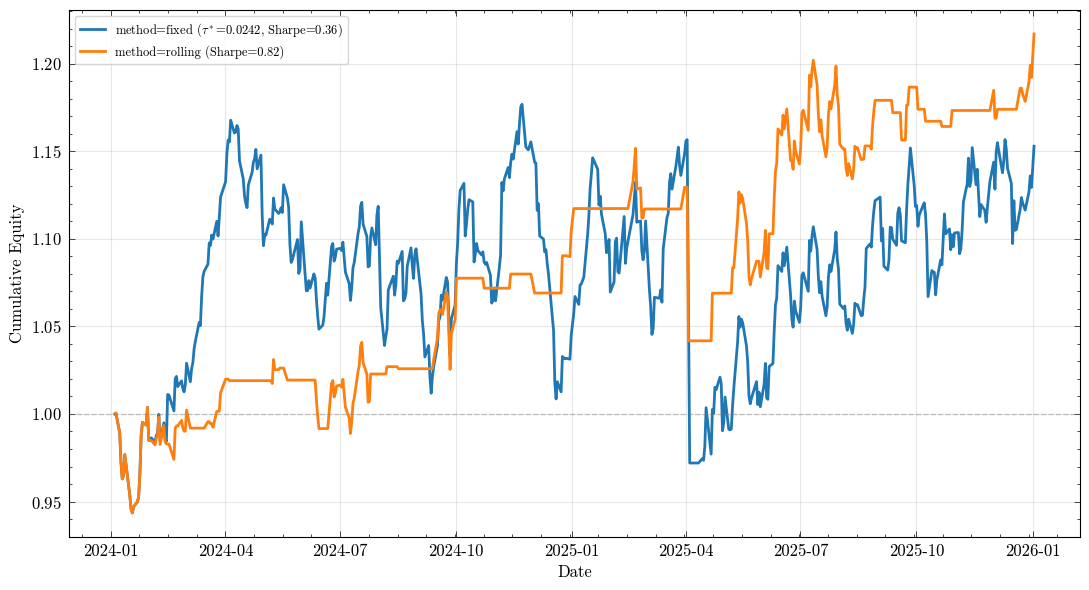

In [133]:
methods = ["fixed", "rolling"]


out_sweep = sweep_one_param_and_plot(
    df=df,
    values=methods,
    param_name="method",
)

summary_df = out_sweep["summary"]
equity_long = out_sweep["equity_long"]

In [134]:
summary_df.columns

Index(['run_id', 'method', 'lookback', 'selection_years', 'ret_col',
       'weight_type', 'w_low', 'w_high', 'state_var', 'grid_size',
       'min_quintile', 'rf', 'transaction_cost_bps', 'apply_on', 'lag',
       'tau_star', 'strat_cumulative_return', 'strat_sharpe',
       'strat_sharpe_bh', 'strat_sharpe_buy_regime',
       'strat_sharpe_no_buy_regime', 'strat_num_buy_days',
       'strat_num_no_buy_days', 'strat_turnover', 'strat_max_drawdown'],
      dtype='object')

In [135]:
cols = [
    "method",
    # "ret_col"
    "strat_sharpe",
    "strat_sharpe_buy_regime",
    "strat_sharpe_no_buy_regime",
    "strat_sharpe_bh",
    "strat_turnover",
    "strat_num_buy_days",
    "strat_num_no_buy_days",
]

pretty = summary_df[cols].copy()

# Sharpe difference (low − high or buy − no-buy depending on your definition)
pretty["sharpe_diff"] = (
    pretty["strat_sharpe_buy_regime"]
    - pretty["strat_sharpe_no_buy_regime"]
)

# Rename columns for presentation
pretty = pretty.rename(columns={
    "method": "Cross-Validation Method",
    "strat_sharpe": "Sharpe (Overall)",
    "strat_sharpe_buy_regime": "Sharpe (Buy Regime)",
    "strat_sharpe_no_buy_regime": "Sharpe (No-Buy Regime)",
    "sharpe_diff": "Δ Sharpe (Buy − No-Buy)",
    "strat_turnover": "Turnover",
    "strat_num_buy_days": "# Buy Days",
    "strat_num_no_buy_days": "# No-Buy Days",
})

pretty

,Cross-Validation Method,Sharpe (Overall),Sharpe (Buy Regime),Sharpe (No-Buy Regime),strat_sharpe_bh,Turnover,# Buy Days,# No-Buy Days,Δ Sharpe (Buy − No-Buy)
0,fixed,0.356557,0.644697,-6.618075,0.290704,2.0,495,5,7.262772
1,rolling,0.822309,1.997206,-0.408817,0.290704,97.0,192,308,2.406024


#### execution type

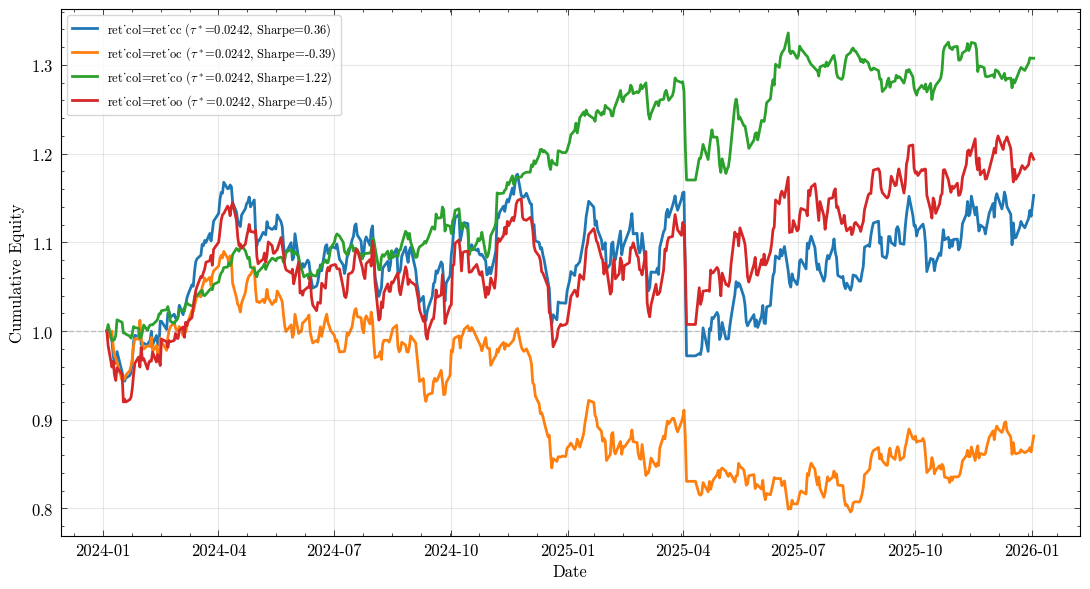

In [146]:
execution_type = ["ret_cc", "ret_oc" , "ret_co", "ret_oo"]

out_sweep = sweep_one_param_and_plot(
    df=df,
    values=execution_type,
    param_name="ret_col",
)


summary_df = out_sweep["summary"]
equity_long = out_sweep["equity_long"]


In [147]:
cols = [
    "ret_col",
    "strat_sharpe",
    "strat_sharpe_buy_regime",
    "strat_sharpe_no_buy_regime",
    "strat_sharpe_bh",
    "strat_turnover",
    "strat_num_buy_days",
    "strat_num_no_buy_days",
]

pretty = summary_df[cols].copy()

# Sharpe difference (low − high or buy − no-buy depending on your definition)
pretty["sharpe_diff"] = (
    pretty["strat_sharpe_buy_regime"]
    - pretty["strat_sharpe_no_buy_regime"]
)

# Rename columns for presentation
pretty = pretty.rename(columns={
    "ret_col": "Execution Type",
    "strat_sharpe": "Sharpe (Overall)",
    "strat_sharpe_buy_regime": "Sharpe (Buy Regime)",
    "strat_sharpe_no_buy_regime": "Sharpe (No-Buy Regime)",
    "sharpe_diff": "Δ Sharpe (Buy − No-Buy)",
    "strat_turnover": "Turnover",
    "strat_num_buy_days": "# Buy Days",
    "strat_num_no_buy_days": "# No-Buy Days",
})

pretty

,Execution Type,Sharpe (Overall),Sharpe (Buy Regime),Sharpe (No-Buy Regime),strat_sharpe_bh,Turnover,# Buy Days,# No-Buy Days,Δ Sharpe (Buy − No-Buy)
0,ret_cc,0.356557,0.644697,-6.618075,0.290704,2.0,495,5,7.262772
1,ret_oc,-0.386099,-0.222624,-1.913225,-0.286811,2.0,495,5,1.690602
2,ret_co,1.218736,1.465382,-11.378607,0.980112,2.0,495,5,12.843989
3,ret_oo,0.449514,0.602458,-5.279503,0.267090,2.0,495,5,5.881961


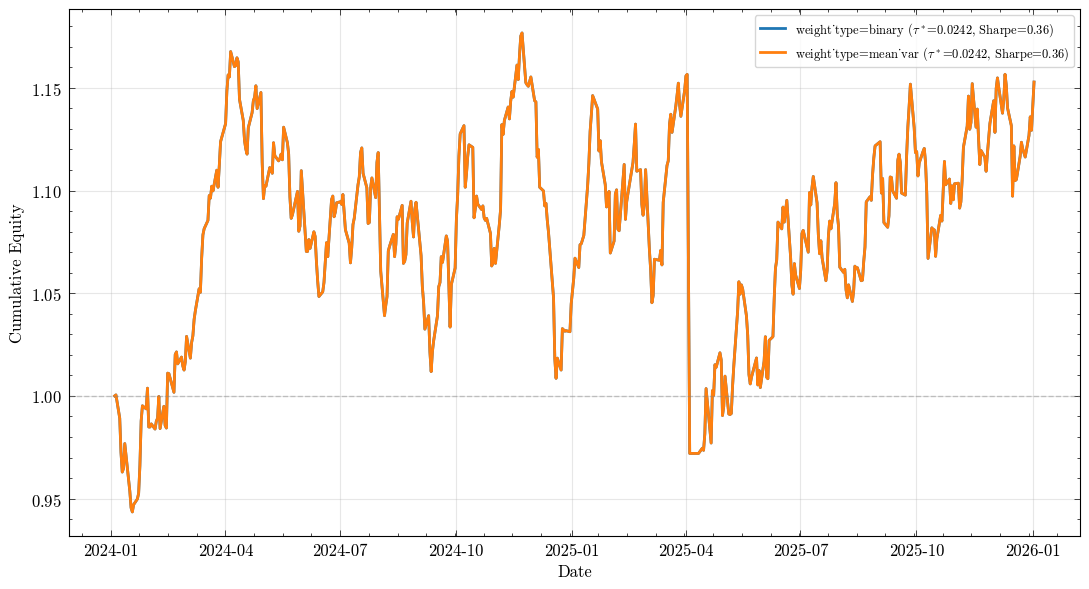

In [138]:
weight_type = ["binary", "mean_var"]


out_sweep = sweep_one_param_and_plot(
    df=df, 
    values=weight_type,
    param_name="weight_type",
)

summary_df = out_sweep["summary"]
equity_long = out_sweep["equity_long"]

In [139]:
cols = [
    "weight_type",
    "strat_sharpe",
    "strat_sharpe_buy_regime",
    "strat_sharpe_no_buy_regime",
    "strat_sharpe_bh",
    "strat_turnover",
    "strat_num_buy_days",
    "strat_num_no_buy_days",
]

pretty = summary_df[cols].copy()

# Sharpe difference (low − high or buy − no-buy depending on your definition)
pretty["sharpe_diff"] = (
    pretty["strat_sharpe_buy_regime"]
    - pretty["strat_sharpe_no_buy_regime"]
)

# Rename columns for presentation
pretty = pretty.rename(columns={
    "weight_type": "Weight Allocation",
    "strat_sharpe": "Sharpe (Overall)",
    "strat_sharpe_buy_regime": "Sharpe (Buy Regime)",
    "strat_sharpe_no_buy_regime": "Sharpe (No-Buy Regime)",
    "sharpe_diff": "Δ Sharpe (Buy − No-Buy)",
    "strat_turnover": "Turnover",
    "strat_num_buy_days": "# Buy Days",
    "strat_num_no_buy_days": "# No-Buy Days",
})

pretty

,Weight Allocation,Sharpe (Overall),Sharpe (Buy Regime),Sharpe (No-Buy Regime),strat_sharpe_bh,Turnover,# Buy Days,# No-Buy Days,Δ Sharpe (Buy − No-Buy)
0,binary,0.356557,0.644697,-6.618075,0.290704,2.0,495,5,7.262772
1,mean_var,0.356557,0.644697,-6.618075,0.290704,2.0,495,5,7.262772


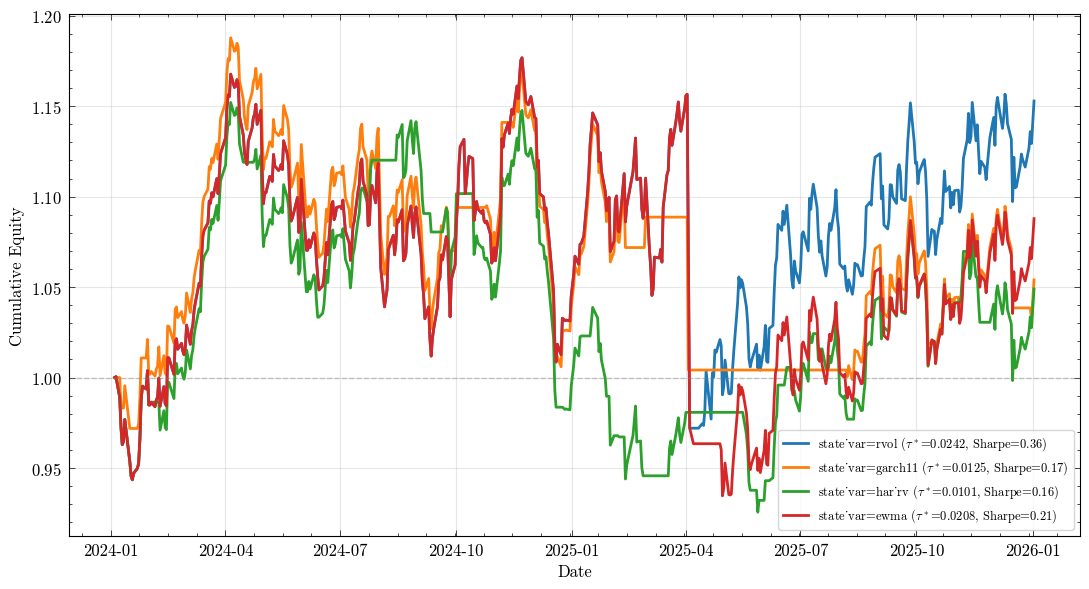

In [140]:
state_var = ["rvol", "garch11" , "har_rv", "ewma"]


out_sweep = sweep_one_param_and_plot(
    df=df,
    values=state_var,
    param_name="state_var",
)

summary_df = out_sweep["summary"]
equity_long = out_sweep["equity_long"]

In [141]:
cols = [
    "state_var",
    "strat_sharpe",
    "strat_sharpe_buy_regime",
    "strat_sharpe_no_buy_regime",
    "strat_sharpe_bh",
    "strat_turnover",
    "strat_num_buy_days",
    "strat_num_no_buy_days",
]

pretty = summary_df[cols].copy()

# Sharpe difference (low − high or buy − no-buy depending on your definition)
pretty["sharpe_diff"] = (
    pretty["strat_sharpe_buy_regime"]
    - pretty["strat_sharpe_no_buy_regime"]
)

# Rename columns for presentation
pretty = pretty.rename(columns={
    "state_var": "State Variable",
    "strat_sharpe": "Sharpe (Overall)",
    "strat_sharpe_buy_regime": "Sharpe (Buy Regime)",
    "strat_sharpe_no_buy_regime": "Sharpe (No-Buy Regime)",
    "sharpe_diff": "Δ Sharpe (Buy − No-Buy)",
    "strat_turnover": "Turnover",
    "strat_num_buy_days": "# Buy Days",
    "strat_num_no_buy_days": "# No-Buy Days",
})

pretty

,State Variable,Sharpe (Overall),Sharpe (Buy Regime),Sharpe (No-Buy Regime),strat_sharpe_bh,Turnover,# Buy Days,# No-Buy Days,Δ Sharpe (Buy − No-Buy)
0,rvol,0.356557,0.644697,-6.618075,0.290704,2.0,495,5,7.262772
1,garch11,0.166919,0.652765,-0.076608,0.290704,34.0,328,172,0.729373
2,har_rv,0.161020,0.353500,0.208638,0.290704,78.0,358,142,0.144862
3,ewma,0.213904,0.214187,1.504813,0.290704,2.0,486,14,-1.290626


### Sweep 

In [142]:
from __future__ import annotations

from itertools import product
import pandas as pd

def run_sweep(
    *,
    df: pd.DataFrame, 
    method: list[str],
    weight_type: list[str],
    execution_type: list[str],          # maps to ret_col in run_one
    # transaction_costs: list[int | float],
    state_vars: list[str],
    # optional passthrough / fixed params:
    **fixed_run_one_kwargs,
) -> dict:
    summaries: list[dict] = []
    equities: list[pd.DataFrame] = []


    for m, wt, ret_col, state_var in product(method, weight_type, execution_type, state_vars):

        out = run_one(
            df = df,
            method=m,
            weight_type=wt,
            ret_col=ret_col,
            # transaction_cost_bps=float(tcost_bps),
            state_var = state_var,
            **fixed_run_one_kwargs,   # e.g. selection_years=2, lookback=252, etc.
        )

        # required outputs
        summaries.append(out["summary"])
        equities.append(out["equity_long"])


    runs_summary = pd.DataFrame(summaries)
    equity_curves = pd.concat(equities, ignore_index=True) if equities else pd.DataFrame()

    result = {
        "runs_summary": runs_summary,
        "equity_curves": equity_curves,
    }


    return result


In [143]:
def save_dashboard_tables(
    out: dict,
    *,
    tag: str = "state_sweep",
) -> dict:
    """
    Saves dashboard tables to: root/data/dashboard/<tag>/
    Assumes notebook is run from root/notebooks/
    """

    # notebook cwd = root/notebooks
    project_root = Path.cwd().parent   # go up to root/
    base = project_root / "results" / tag
    base.mkdir(parents=True, exist_ok=True)

    paths = {}


    runs_path = base / "runs_summary.parquet"
    out["runs_summary"].to_parquet(runs_path, index=False)
    paths["runs_summary"] = str(runs_path)

    eq_dir = base / "equity_curves.parquet"     # directory, not file
    out["equity_curves"].to_parquet(
        eq_dir,
        index=False,
        # partition_cols=["run_id"],
    )

    paths["equity_curves"] = str(eq_dir)

    return paths

In [144]:
# sweep_out = run_sweep(
#     df = df, 
#     method = ['fixed', 'rolling'], 
#     weight_type = ['fixed', 'mean_var'], 
#     execution_type= ['ret_cc', 'ret_co', 'ret_oc', 'ret_oo'],
#     state_vars= ["rvol", "garch11" , "har_rv", "ewma"],
#     # transaction_costs = [0, 3, 5],
# )

In [145]:
# paths = save_dashboard_tables(sweep_out, tag="state_pred_sweep")
# print(paths)
